In [2]:
import pandas as pd 
import numpy as np
import featuretools as ft
RSEED = 50

members = pd.read_csv('members_v3_1k.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True, 
                      dtype = {'gender': 'category'})

trans = pd.read_csv('transactions_1k.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True)

logs = pd.read_csv('user_logs_1k.csv', parse_dates = ['date'])

cutoff_times = pd.read_csv('label_times.csv', parse_dates = ['cutoff_time'])

In [3]:
# Make empty entityset
es = ft.EntitySet(id = 'customers')

In [4]:
# Create entity from members
import featuretools.variable_types as vtypes
es.entity_from_dataframe(entity_id='members', dataframe=members,
                         index = 'msno', time_index = 'registration_init_time', 
                         variable_types = {'city': vtypes.Categorical, 
                                           'registered_via': vtypes.Categorical})

Entityset: customers
  Entities:
    members [Rows: 882, Columns: 6]
  Relationships:
    No relationships

In [5]:
# Filter anomalies
trans = trans[trans['membership_expire_date'] > trans['transaction_date']]


In [6]:
# Create entity from transactions
es.entity_from_dataframe(entity_id='transactions', dataframe=trans,
                         index = 'transactions_index', make_index = True,
                         time_index = 'transaction_date', 
                         variable_types = {'payment_method_id': vtypes.Categorical, 
                                           'is_auto_renew': vtypes.Boolean, 'is_cancel': vtypes.Boolean})

Entityset: customers
  Entities:
    members [Rows: 882, Columns: 6]
    transactions [Rows: 16351, Columns: 10]
  Relationships:
    No relationships

In [7]:
es.entity_from_dataframe(entity_id='logs', dataframe=logs,
                         index = 'logs_index', make_index = True,
                         time_index = 'date')

Entityset: customers
  Entities:
    logs [Rows: 252022, Columns: 10]
    members [Rows: 882, Columns: 6]
    transactions [Rows: 16351, Columns: 10]
  Relationships:
    No relationships

In [8]:
# Relationships (parent, child)
r_member_transactions = ft.Relationship(es['members']['msno'], es['transactions']['msno'])
r_member_logs = ft.Relationship(es['members']['msno'], es['logs']['msno'])

es.add_relationships([r_member_transactions, r_member_logs])

Entityset: customers
  Entities:
    logs [Rows: 252022, Columns: 10]
    members [Rows: 882, Columns: 6]
    transactions [Rows: 16351, Columns: 10]
  Relationships:
    transactions.msno -> members.msno
    logs.msno -> members.msno

In [9]:
cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'cutoff_time'])

In [10]:
#only taking sum and mean as an aggregation function for the baseline model
# Specify aggregation primitives
agg_primitives = ['sum', 'mean']
where_primitives = ['sum', 'mean']

In [11]:
from timeit import default_timer as timer

start = timer()
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='members', 
                                      cutoff_time = cutoff_times, 
                                      agg_primitives = agg_primitives,
                                      where_primitives = where_primitives,
                                      max_depth = 1, features_only = False,
                                      verbose = 1, chunk_size = 1000,  
                                      n_jobs = -1,
                                      cutoff_time_in_index = True)
end = timer()
print('seconds elapsed.', {round(end - start)} )

Built 28 features


/home/sahil94/.local/lib/python3.5/site-packages/distributed/bokeh/core.py:13: UserWarning: 
Dask needs bokeh >= 0.13.0 for the dashboard.
Continuing without the dashboard.
  warnings.warn("\nDask needs bokeh >= 0.13.0 for the dashboard."


EntitySet scattered to workers in 2.995 seconds
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 22/22 chunks
seconds elapsed. {22}


In [12]:
fm = feature_matrix.reset_index()
fm.head()

,msno,time,bd,registered_via,city,gender,SUM(logs.num_50),SUM(logs.num_75),MEAN(logs.num_75),SUM(transactions.payment_plan_days),...,MEAN(logs.num_50),SUM(logs.num_25),SUM(transactions.actual_amount_paid),SUM(logs.total_secs),MEAN(logs.num_985),MEAN(logs.num_unq),MEAN(transactions.payment_plan_days),label,days_to_churn,churn_date
0,+6KodETinDioAsOrJjj1UH425xG3uM6N/bd49J15How=,2015-01-01,0.0,7.0,1.0,NaN,0.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.000,NaN,NaN,NaN,0.0,NaN,NaN
1,+WiZkfIp5sDsf0xZvBnR2j6Kxi1u2k0t0mJBJqhQIJo=,2015-01-01,25.0,9.0,13.0,male,1.0,1.0,1.0,0.0,...,1.0,8.0,0.0,2106.478,0.0,17.0,NaN,0.0,472.0,NaN
2,+eELJ1gSSkwJItUOLgavd0hFy/TLj0RVrcaPgQunOPM=,2015-01-01,0.0,9.0,14.0,NaN,0.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.000,NaN,NaN,NaN,0.0,470.0,NaN
3,+s3jJdEWKI0aVm/aTtJjbl1/6m9T+Fdshe1opAtZTy8=,2015-01-01,0.0,7.0,1.0,NaN,0.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.000,NaN,NaN,NaN,0.0,NaN,NaN
4,/OrkK+agRQCMhB2GK3KctomRLGCQuWxUqw9ml1eQNog=,2015-01-01,22.0,9.0,11.0,male,0.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.000,NaN,NaN,NaN,0.0,480.0,NaN


In [13]:
fm = feature_matrix.copy()
fm = fm.reset_index()
fm.drop(columns=["days_to_churn", "churn_date"], inplace=True)
fm = fm.dropna(subset=["label"])
fm = fm.drop_duplicates(subset = ['msno', 'time'])
fm = pd.get_dummies(fm.drop(columns=['time', 'msno']))
fm = fm[(fm.bd<120) & (fm.bd>6)]
fm = fm.fillna(fm.mean())

In [14]:
X = fm.drop(columns=['label'])
y = fm['label']

In [15]:
import lightgbm as lgb

RSEED = 40

def cross_validate(X, y):
    """Compute cross validation ROC AUC of a gradient boosting model for a given training dataset"""
    
    # Extract the labels
    train_labels = y
    train = X

    # Create a  lgb training set
    train_set = lgb.Dataset(train, label = train_labels)

    # Find default hyperparameters
    model = lgb.LGBMClassifier()
    params = model.get_params()

    # Number of estimators will be selected through early stopping
    del params['n_estimators'], params['silent']

    # Early stoppping with 5 fold cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)

    print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))

    print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))
    
    return cv_results

In [17]:
cv_results_baseline = cross_validate(X, y)

Cross Validation ROC AUC: 0.79239 with std: 0.01268.
Number of estimators trained: 8


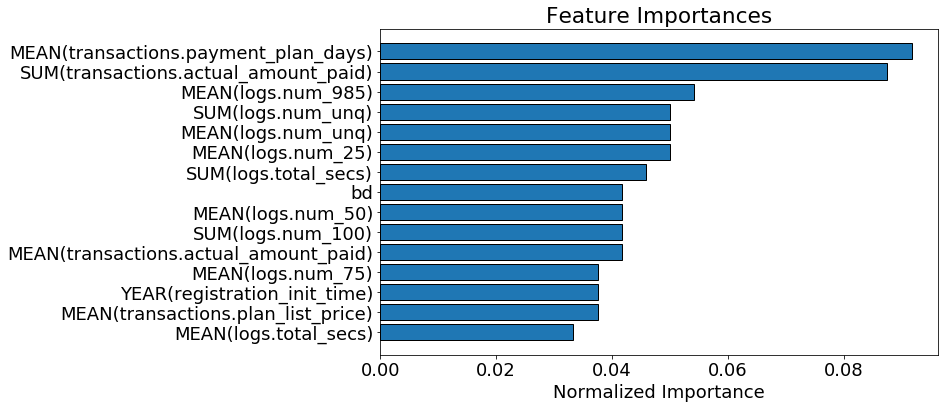

,index,feature,importance,importance_normalized,cumulative_importance
0,26,MEAN(transactions.payment_plan_days),22,0.091667,0.091667
1,22,SUM(transactions.actual_amount_paid),21,0.087500,0.179167
2,24,MEAN(logs.num_985),13,0.054167,0.233333
3,15,SUM(logs.num_unq),12,0.050000,0.283333
4,25,MEAN(logs.num_unq),12,0.050000,0.333333
5,8,MEAN(logs.num_25),12,0.050000,0.383333
6,23,SUM(logs.total_secs),11,0.045833,0.429167
7,0,bd,10,0.041667,0.470833
8,20,MEAN(logs.num_50),10,0.041667,0.512500
9,10,SUM(logs.num_100),10,0.041667,0.554167


In [20]:
## Feature Importance
#X = kkbox_reduced

# New model fit on the training data
model = lgb.LGBMClassifier(n_estimators = len(cv_results_baseline['auc-mean']), random_state = RSEED)
model.fit(X, y)

# Put feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': list(X.columns), 
                                    'importance': model.feature_importances_})

import matplotlib.pyplot as plt

def plot_feature_importances(df):
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    
    return df
norm_fi = plot_feature_importances(feature_importances)
norm_fi.head(20)